In [1]:
from IPython.display import display, Math, Latex

In [2]:
import numpy as np
import pandas as pd
# import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.feature_selection import RFE, RFECV, f_regression
from sklearn.datasets import load_boston
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.cross_validation import KFold, train_test_split , cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, roc_auc_score, roc_curve, confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer


/usr/people/weichun/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [6]:
import csv

In [8]:
feature_cols = ["employee_index","country_residence","sex","age","first_join_date","new_customer_index","seniority","primary","customer_type","customer_relation","residence_idx","foreigner_idx","channel","deceased","address","province_code","province_name","activity_idx","gross_income","segment"]
#target_cols=["saving_account","guarantees","current_account","derivada_account","payroll_account","junior_account","mas_particular_account","particular_account","particular_plus_account","short-term_deposits","medium-term_deposits","long-term_deposits","e-account","funds","mortgage","pensions","loans","taxes","credit_card","securities","home_account","payroll","pensions_1","direct_debit"]
#target_cols = target_cols[2:]
target_cols = ["current_account"]
all_cols = feature_cols+target_cols

In [9]:
def getTarget(row):
    tlist = []
    for col in target_cols:
            if row[col].strip() in ['', 'NA']:
                    target = 0
            else:
                    target = int(float(row[col]))
            tlist.append(target)
    return tlist

In [4]:
def processData(in_file_name):
    x_vars_list = []
    #y_vars_list = []
    for row in csv.DictReader(in_file_name, fieldnames = ( "date","id","employee_index","country_residence","sex",
                                                          "age","first_join_date","new_customer_index","seniority",
                                                          "primary","last_date_primary","customer_type","customer_relation",
                                                          "residence_idx","foreigner_idx","spouse_idx","channel","deceased",
                                                          "address","province_code","province_name","activity_idx",
                                                          "gross_income","segment","saving_account","guarantees",
                                                          "current_account","derivada_account","payroll_account",
                                                          "junior_account","mas_particular_account","particular_account",
                                                          "particular_plus_account","short-term_deposits","medium-term_deposits",
                                                          "long-term_deposits","e-account","funds","mortgage","pensions","loans",
                                                          "taxes","credit_card","securities","home_account","payroll",
                                                          "pensions_1","direct_debit" )):
        x_vars = []
        for col in feature_cols:
            val = row[col].strip()
            x_vars.append(val)
            
        if row['date'] in [ '2016-05-28']:
            target_list = getTarget(row)
            x_vars_list.append(x_vars + target_list)
            
#assign a number for the test data
        elif row['date'] in ['2016-06-28']: 
             target_list = [0]
             x_vars_list.append(x_vars + target_list)
        else:
            continue

    return x_vars_list

In [10]:

start_time = datetime.datetime.now()
data_path = "../input/"
train_file =  open(data_path + "train_ver2.csv")
#train_file =  open(data_path + "train_20percent.csv")
x_vars_list = processData(train_file)


df_org = pd.DataFrame.from_records(x_vars_list, columns=all_cols)
df = df_org
print("Number of columns in the dataframe:")
print(len(x_vars_list[1]))  
print("Number of records in the dataframe:")
print(len(df))

Number of columns in the dataframe:
21
Number of records in the dataframe:
931453


In [11]:
df_org = df

In [12]:
df['customer_type']=df['customer_type'].replace('1.0','1')
df['customer_type']=df['customer_type'].replace('2.0','2')
df['customer_type']=df['customer_type'].replace('3.0','3')
df['customer_type']=df['customer_type'].replace('4.0','4')

In [13]:
#Age and seniority may have non-numeric values. Use errors='coerce' to force them to be NaN so they can be removed.

df['age']   = pd.to_numeric(df['age'], errors='coerce')
df['seniority']   = pd.to_numeric(df['seniority'], errors='coerce')
df['gross_income']   = pd.to_numeric(df['gross_income'], errors='coerce')

##df = df[df['seniority']>0]
##df.dropna(axis=0)
#df.dropna()

#select the rows that do not have NaN
condition=~pd.isnull(df).any(axis=1)
df=df[condition]
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 702435 entries, 0 to 931451
Data columns (total 21 columns):
employee_index        702435 non-null object
country_residence     702435 non-null object
sex                   702435 non-null object
age                   702435 non-null int64
first_join_date       702435 non-null object
new_customer_index    702435 non-null object
seniority             702435 non-null int64
primary               702435 non-null object
customer_type         702435 non-null object
customer_relation     702435 non-null object
residence_idx         702435 non-null object
foreigner_idx         702435 non-null object
channel               702435 non-null object
deceased              702435 non-null object
address               702435 non-null object
province_code         702435 non-null object
province_name         702435 non-null object
activity_idx          702435 non-null object
gross_income          702435 non-null float64
segment               702435 non-nu

In [14]:
def prep_numeric_data(df):
    
    from sklearn import preprocessing
    le = preprocessing.LabelEncoder()
    feature_cols = df.columns 
    for ind, feature_col in enumerate(feature_cols):
        if df[feature_col].dtype == 'object':
            le.fit(df[feature_col])
            df[feature_col]=le.transform(df[feature_col])
    
    return df

In [15]:
df = prep_numeric_data(df)

/usr/people/weichun/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [16]:
print("Number of columns in the dataframe:")
print(len(x_vars_list[1]))  
print("Number of records in the dataframe:")
print(len(df))

Number of columns in the dataframe:
21
Number of records in the dataframe:
702435


In [30]:
# split data into train and test sets
X = df.drop(['address','current_account'],axis=1).values
y = df['current_account'].values
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

In [34]:
X_df = df.drop(['address','current_account'],axis=1)


Lets split the data in test and train splits - why is this important ?

In [ ]:
X_train

X, y = dataset.iloc[:, :13].values, dataset.iloc[:, 13].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [31]:
print ('Train data', len(X_train))
print ('Test data', len(X_test))

Train data 470631
Test data 231804


### Base Model

Lets establish a baseline by building a base model

In [19]:
logit = LogisticRegression()
logit.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [20]:
print ('Training AUC-RIC :', roc_auc_score(y_train, logit.predict_proba(X_train)[:,1]))
print ('Test AUC-ROC :', roc_auc_score(y_test, logit.predict_proba(X_test)[:,1]))
print ('Accuracy Train :', accuracy_score(y_train, logit.predict(X_train)))
print ('Accuracy Test :',  accuracy_score(y_test, logit.predict(X_test)))

Training AUC-RIC : 0.621722217682
Test AUC-ROC : 0.621773825356
Accuracy Train : 0.602406131343
Accuracy Test : 0.602427050439


In [21]:
fpr, tpr, thresholds = roc_curve(y_test, logit.predict_proba(X_test)[:,1], pos_label=1)
roc = roc_auc_score(y_test, logit.predict_proba(X_test)[:,1])

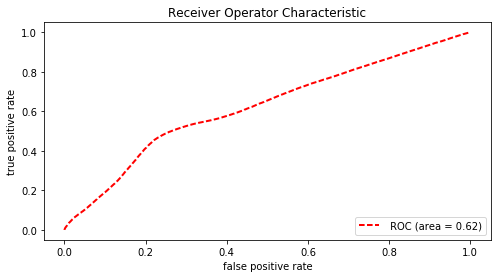

In [22]:
# plot ROC curve
plt,figure(figsize=(8,4))
plt.plot(fpr, tpr, 'r--', label=' ROC (area = %0.2f)' % roc, lw=2)
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver Operator Characteristic')
plt.legend(loc="lower right")

In [24]:
print (classification_report(y_test, logit.predict(X_test)))
print (confusion_matrix(y_test, logit.predict(X_test)))

             precision    recall  f1-score   support

          0       0.51      0.13      0.20     92493
          1       0.61      0.92      0.74    139311

avg / total       0.57      0.60      0.52    231804

[[ 11624  80869]
 [ 11290 128021]]


###  Nonlinearity - Interactions ans cross terms 

Very often we know that combining features we already know of to form new features help improve our model. In practice, this is done by creating feature iteractions / crossing different features to see which combinations add the most value to the model. 

In [12]:
## Building base model
logit_interactions = LogisticRegression()
crossvalidation = KFold(n=X.shape[0], n_folds=10, shuffle=True, random_state=1)

In [63]:
# Adding interaction to model
df = pd.DataFrame(X,columns=boston.feature_names)
baseline = np.mean(cross_val_score(logit_interactions, df, y, scoring='accuracy', cv=crossvalidation, n_jobs=1))
interactions = list()
for feature_A in boston.feature_names:
    for feature_B in boston.feature_names:
        if feature_A > feature_B:
            df['interaction'] = df[feature_A] * df[feature_B]
            score = np.mean(cross_val_score(logit_interactions, df, y, scoring='accuracy',cv=crossvalidation, n_jobs=1))
            if score > baseline:
                interactions.append((feature_A, feature_B, round(score,3)))


In [64]:
print 'Baseline Accuracy: %.3f' % baseline
print 'Top 10 interactions: %s' % sorted(interactions, key=lambda(x):x[2],reverse=True)[:10]

Baseline Accuracy: 0.913
Top 10 interactions: [('RAD', 'DIS', 0.927), ('RM', 'DIS', 0.925), ('DIS', 'CRIM', 0.923), ('RAD', 'AGE', 0.923), ('TAX', 'DIS', 0.923), ('ZN', 'RM', 0.921), ('INDUS', 'DIS', 0.921), ('RM', 'INDUS', 0.921), ('RM', 'AGE', 0.921), ('RM', 'RAD', 0.919)]


In [65]:
# pd.DataFrame(interactions)

### Selecting Features

Here we strive the select the best subset of features that improves the performance of our models. There are many ways to do this but we will focus on just a few techniques.

- Univariate selections of features : You individually model each predictor with the response and select the best features based on some statistical score or p-value. Some examples include f_regression which tests the effect of a single regressor sequentially for many regressors

- Forward / Backward feature selection : This is a class of greedy feature selection algorithms. With Backward feature selection, we start with all the features in the model and then eliminate one feature at a time until we get to point where all the remaining features are either significant or meet a certain p-value threshould that we have defined whereas with Forward feature selection. we basically start modeling the response with one feature and if that feature meets our preset threshlod we keep in the model and add the next feature. One of the issues with forward selection is that you loose the ability ot look ahead.

- Chi2 : chi2 measuree the dependence between stochastic variables, so the chi2 removes featurs that are most likely to be independent of class and therefore not useful for classification

- Recursive Feature Eliminaation : Here, we train on the initial set of features. Then features are assigned weights and subsequently prunned from the model. This process continues until we get the desired number of features



### Recursive Feature Eliminaation

In [25]:
# create ranking among all features by selecting only one
rfe = RFE(LogisticRegression(), n_features_to_select=1)
rfe.fit(X_train, y_train)
rfe.ranking_

array([ 6,  7,  8,  9, 13, 18, 14, 15, 19,  4,  3,  5, 10, 16, 11, 12,  1,
       17,  2])

In [26]:
X_train.columns

Index(['employee_index', 'country_residence', 'sex', 'age', 'first_join_date',
       'new_customer_index', 'seniority', 'primary', 'customer_type',
       'customer_relation', 'residence_idx', 'foreigner_idx', 'channel',
       'deceased', 'province_code', 'province_name', 'activity_idx',
       'gross_income', 'segment'],
      dtype='object')

In [22]:
# pipe_rfe_poly = Pipeline([('scale_standard', StandardScaler()),
#                      ('poly_features', PolynomialFeatures()),
#                      ('rfe_logit', RFECV(LogisticRegression(), cv=10))])
# pipe_rfe_poly.fit(X_train, y_train)
# pipe_rfe_poly.score(X_test, y_test)

In [27]:
## using RFECV
rfe = RFECV(LogisticRegression(), cv=10)
rfe.fit(X_train, y_train)
print(rfe.support_)
#print(boston.feature_names[rfe.support_])
print(X_train.columns[rfe.support_])

[ True  True  True False False False False False False  True  True  True
 False False False False  True False  True]
Index(['employee_index', 'country_residence', 'sex', 'customer_relation',
       'residence_idx', 'foreigner_idx', 'activity_idx', 'segment'],
      dtype='object')


### Forward / Backward feature selection

In [29]:
type(X_train)

pandas.core.frame.DataFrame

In [32]:
# Forward Feature selection
from mlxtend.feature_selection import SequentialFeatureSelector
sfs = SequentialFeatureSelector(LogisticRegression(), forward=True, floating = False, k_features=7, verbose = 2)
sfs.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:   41.8s finished

[2017-09-06 14:32:04] Features: 1/7 -- score: 0.603066946501[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:   58.4s finished

[2017-09-06 14:33:03] Features: 2/7 -- score: 0.603861632655[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:  1.2min finished

[2017-09-06 14:34:17] Features: 3/7 -- score: 0.684672288824[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:  1.4min finished

[2017-09-06 14:35:41] Features: 4/7 -- score: 0.710539693066[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  1.6min finished

[2017

SequentialFeatureSelector(clone_estimator=True, cv=5,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
             floating=False, forward=True, k_features=7, n_jobs=1,
             pre_dispatch='2*n_jobs', scoring=None, skip_if_stuck=True,
             verbose=2)

In [36]:
print(sfs.k_feature_idx_)
#print(boston.feature_names[np.array(sfs.k_feature_idx_)])
print(X_df.columns[np.array(sfs.k_feature_idx_)])

(0, 3, 7, 10, 15, 16, 18)
Index(['employee_index', 'age', 'primary', 'residence_idx', 'province_name',
       'activity_idx', 'segment'],
      dtype='object')


In [37]:
# Backward Feature selection
sbs = SequentialFeatureSelector(LogisticRegression(), forward=False, floating = False, k_features=7, verbose = 2)
sbs.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed: 19.4min finished

[2017-09-06 15:16:01] Features: 18/7 -- score: 0.623362915637[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   53.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed: 15.8min finished

[2017-09-06 15:31:51] Features: 17/7 -- score: 0.710518444681[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   30.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed: 10.8min finished

[2017-09-06 15:42:40] Features: 16/7 -- score: 0.710686306386[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   37.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed: 12.3min finished

[2017-09-06 15:55:00] Features: 15/7 -- score: 0.711036894018[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   54.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 10.8min finished

[

SequentialFeatureSelector(clone_estimator=True, cv=5,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
             floating=False, forward=False, k_features=7, n_jobs=1,
             pre_dispatch='2*n_jobs', scoring=None, skip_if_stuck=True,
             verbose=2)

In [38]:
print(sbs.k_feature_idx_)
print(X_df.columns[np.array(sbs.k_feature_idx_)])

(0, 2, 7, 12, 14, 16, 18)
Index(['employee_index', 'sex', 'primary', 'channel', 'province_code',
       'activity_idx', 'segment'],
      dtype='object')


In [39]:
pd.DataFrame(sfs.get_metric_dict()).T

,avg_score,ci_bound,cv_scores,feature_idx,std_dev,std_err
1,0.603067,7.78843e-05,"[0.603142562708, 0.60304694721, 0.602961955656...","(7,)",6.05966e-05,3.02983e-05
2,0.603862,0.00145923,"[0.604459931794, 0.602016424618, 0.60308944298...","(3, 7)",0.00113533,0.000567665
3,0.684672,0.00222448,"[0.68597745599, 0.681441031797, 0.684617591127...","(16, 3, 7)",0.00173072,0.000865361
4,0.71054,0.0028924,"[0.711273067239, 0.706386052886, 0.71081623763...","(16, 18, 3, 7)",0.00225038,0.00112519
5,0.710552,0.00289051,"[0.711283691183, 0.70639667683, 0.710816237636...","(3, 7, 10, 16, 18)",0.00224891,0.00112446
6,0.710561,0.0029031,"[0.711283691183, 0.70639667683, 0.710837485525...","(0, 3, 7, 10, 16, 18)",0.00225871,0.00112936
7,0.710601,0.00289929,"[0.711368682737, 0.706417924719, 0.71086935735...","(0, 3, 7, 10, 15, 16, 18)",0.00225575,0.00112787


In [40]:
pd.DataFrame(sbs.get_metric_dict()).T

,avg_score,ci_bound,cv_scores,feature_idx,std_dev,std_err
7,0.710578,0.00290507,"[0.711368682737, 0.706386052886, 0.71084810946...","(0, 2, 7, 12, 14, 16, 18)",0.00226024,0.00113012
8,0.710584,0.00289527,"[0.711368682737, 0.706407300774, 0.71085873341...","(0, 2, 7, 11, 12, 14, 16, 18)",0.00225262,0.00112631
9,0.710584,0.00289527,"[0.711368682737, 0.706407300774, 0.71085873341...","(0, 2, 5, 7, 11, 12, 14, 16, 18)",0.00225262,0.00112631
10,0.710584,0.00289527,"[0.711368682737, 0.706407300774, 0.71085873341...","(0, 2, 5, 7, 8, 11, 12, 14, 16, 18)",0.00225262,0.00112631
11,0.710584,0.00289527,"[0.711368682737, 0.706407300774, 0.71085873341...","(0, 2, 5, 7, 8, 11, 12, 13, 14, 16, 18)",0.00225262,0.00112631
12,0.710582,0.00289697,"[0.711358058793, 0.706407300774, 0.71085873341...","(0, 2, 5, 6, 7, 8, 11, 12, 13, 14, 16, 18)",0.00225394,0.00112697
13,0.71058,0.00290828,"[0.711368682737, 0.706386052886, 0.71084810946...","(0, 2, 5, 6, 7, 8, 10, 11, 12, 13, 14, 16, 18)",0.00226274,0.00113137
14,0.712199,0.00446799,"[0.716914381633, 0.706417924719, 0.71085873341...","(0, 2, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16,...",0.00347625,0.00173812
15,0.711037,0.003344,"[0.713684702583, 0.706375428942, 0.71081623763...","(0, 2, 3, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, ...",0.00260174,0.00130087
16,0.710686,0.00310907,"[0.711347434849, 0.706386052886, 0.71079498974...","(0, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...",0.00241896,0.00120948


### Evaluating and Comparing Models
- Confusion matriz : is basically a table that summarizes the performance of classification tasks across TP, TN, FP and FN. It also allows us to calculate several other metrics useful for classification problems
- Area under the ROC curve : this is a plot of TPR (sensitivity) vs FPR (1 - specificity) for every possible classification threshold. It is a single graph / number summary for classifier performance. . It is also useful to understand the tradeoffs in classifier performance
- Accuracy : this measures how ofter the classifier makes the correct prediction. It's easy to calculate but it doesn't tell us anything about the dependent values or the type of errors your classifier is making 
- Precision and Recall : Precision tell how often the prediction is correct when our classifier predicts a positive value whereas Recall tells us how often the prediction is correct when the actual value is positive

$$Recall = \frac{TP}{FN + TP}$$

$$Precision = \frac{TP}{FP + TP} $$

### Overfitting / Underfitting 


### Other Topics / Model Tyoes
- Regularization : assign an appropriate penalty for model complexity (L1 , L2)
- SVM : is large margin classifier. It provides a binary classification mechanism based on finding a hyperplane between a set of samples with +ve and -ve outputs. It assumes the data is linearly separable.
- Ensemble Trees : Based on a tree of decision nodes, the learning approach is to recursively divide the training data into buckets of homogeneous members through the most discriminative dividing criteria possible. The measurement of “homogeneity” is based on the output label; when it is a numeric value, the measurement will be the variance of the bucket; when it is a category, the measurement will be the entropy, or “gini index,” of the bucket.
- Neural Networks : A Neural Network emulates the structure of a human brain as a network of neurons that are interconnected to each other. Each neuron is technically equivalent to a logistic regression unit.
